# 🏘️ Прогноз цены за м² с ЦИАН: CatBoost + XGBoost (устойчивый к ошибкам)

In [10]:
# !pip install cianparser xgboost catboost scikit-learn pandas matplotlib


In [11]:
from cianparser import CianParser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from catboost import CatBoostRegressor


In [12]:
# 🔄 Загрузка и сохранение данных
parser = CianParser(location="Москва")
data = parser.get_flats(
    deal_type="sale",
    rooms=(1, 2, 3),
    with_saving_csv=True,
    additional_settings={"start_page": 1, "end_page": 25}
)
df = pd.DataFrame(data)
df.to_csv("moscow_flats.csv", index=False)
df.head()



                              Preparing to collect information from pages..
The absolute path to the file: 
c:\Users\sergs\Downloads\cian_flat_sale_1_25_moskva_03_Jun_2025_01_15_45_124570.csv 

The page from which the collection of information begins: 
 https://cian.ru/cat.php?engine_version=2&p=1&with_neighbors=0&region=1&deal_type=sale&offer_type=flat&room1=1&room2=1&room3=1

 1 | 1 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 28. Progress ratio: 4 %. Average price: 331 810 476 rub
 2 | 2 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 56. Progress ratio: 8 %. Average price: 407 903 888 rub
 3 | 3 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 83. Progress ratio: 12 %. Average price: 458 375 685 rub
 4 | 4 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 110. Prog

,author,author_type,url,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price,district,street,house_number,underground,residential_complex
0,ANT Development,developer,https://www.cian.ru/sale/flat/314894284/,Москва,sale,flat,2,10,2,59.80,99866000.0,Дорогомилово,Братьев Фонченко,1к8,Парк Победы,Victory Park Residences
1,hoomie,real_estate_agent,https://www.cian.ru/sale/flat/316895991/,Москва,sale,flat,15,20,2,66.04,29249116.0,Даниловский,Автозаводская,26/1,Тульская,FORST
2,ID 69317500,homeowner,https://www.cian.ru/sale/flat/317766834/,Москва,sale,flat,13,20,3,71.50,16850000.0,,бульвар Скандинавский,1к2,Потапово,
3,Главстрой,developer,https://www.cian.ru/sale/flat/306076627/,Москва,sale,flat,7,26,2,64.50,33128941.0,Филевский парк,Береговой проезд,2,Фили,Береговой-2
4,ID 108172779,real_estate_agent,https://www.cian.ru/sale/flat/315053628/,Москва,sale,flat,5,8,2,111.60,109479600.0,Таганский,Славянская площадь,2/5с1,Китай-город,LUMIN


In [13]:
# 📋 Проверка доступных колонок
print("Колонки в данных:", df.columns.tolist())


Колонки в данных: ['author', 'author_type', 'url', 'location', 'deal_type', 'accommodation_type', 'floor', 'floors_count', 'rooms_count', 'total_meters', 'price', 'district', 'street', 'house_number', 'underground', 'residential_complex']


In [14]:
# 🧹 Предобработка
price_col = "price"
if "total_meters" not in df.columns:
    raise ValueError("❌ Нет колонки 'total_meters' в данных!")

df = df.drop_duplicates()
df = df.dropna(subset=[price_col, "total_meters"])
df[price_col] = df[price_col].astype(float)
df["total_meters"] = df["total_meters"].astype(float)
df = df[(df["total_meters"] > 15) & (df["total_meters"] < 200)]
df["price_per_m2"] = df[price_col] / df["total_meters"]

df = df[(df[price_col] > 1_000_000) & (df[price_col] < 100_000_000)]

# Признаки
df["near_metro"] = df["metro_minutes"].apply(lambda x: x < 10 if pd.notnull(x) else False) if "metro_minutes" in df.columns else False
df["has_renovation"] = df["renovation"].notnull().astype(int) if "renovation" in df.columns else 0
df["floor_ratio"] = df["floor"] / df["floors_count"] if "floor" in df.columns and "floors_count" in df.columns else 0
df["has_balcony"] = df["has_balcony"].astype(int) if "has_balcony" in df.columns else 0

# Категории
if "metro" in df.columns:
    df["metro"] = df["metro"].fillna("unknown")
if "address" in df.columns:
    df["district"] = df["address"].str.extract(r"район\s([^,]+)")

categorical_cols = [col for col in ["metro", "district"] if col in df.columns]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

if "price_per_m2" not in df.columns:
    raise ValueError("❌ price_per_m2 не рассчитан — нет данных по площади.")

y = df["price_per_m2"]
drop_cols = ["description", "address", "phones", "seller", "added_at", "floor", "floors_count", "price"]
X = df.drop(columns=drop_cols, errors="ignore")
X = X.select_dtypes(include=["number", "bool"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# 🚀 XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("📊 XGBoost:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R²:", r2_score(y_test, y_pred_xgb))


📊 XGBoost:
RMSE: 48885.49496038442
R²: 0.9762494576571115


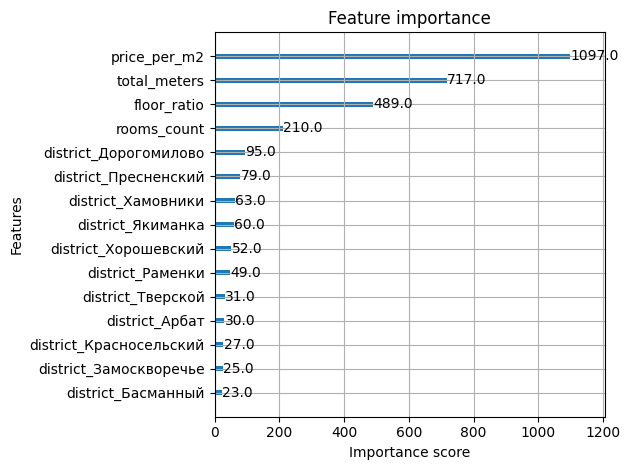

In [16]:
xgb.plot_importance(xgb_model, max_num_features=15)
plt.tight_layout()
plt.show()


In [17]:
# 🚀 CatBoost
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

print("📊 CatBoost:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_cat)))
print("R²:", r2_score(y_test, y_pred_cat))


📊 CatBoost:
RMSE: 44286.02980139304
R²: 0.9805084222931537


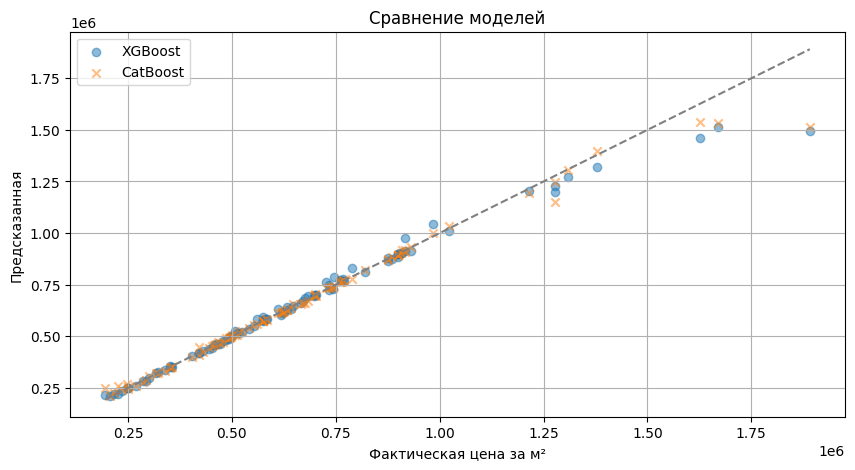

In [18]:
# 📈 Визуализация
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label="XGBoost")
plt.scatter(y_test, y_pred_cat, alpha=0.5, label="CatBoost", marker="x")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="gray")
plt.xlabel("Фактическая цена за м²")
plt.ylabel("Предсказанная")
plt.legend()
plt.grid(True)
plt.title("Сравнение моделей")
plt.show()
